<a href="https://colab.research.google.com/github/Abduoit/4280U-Robotics-Course-1/blob/master/%5BAl_Shanoon%5DCV_DeepLearningChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install colab-ssh

In [1]:
# Install colab_ssh on google colab
!pip install colab_ssh --upgrade

from colab_ssh import launch_ssh_cloudflared, init_git_cloudflared
launch_ssh_cloudflared(password="600198")

# # Optional: if you want to clone a Github or Gitlab repository
# repository_url="<PUT_YOUR_REPOSITORY_URL_HERE>"
# init_git_cloudflared(repository_url)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## This notebook is an intellectual property, not to be shared with others

# Introduction

*In this challenge, you are asked to build a solution capable of segmenting turtles on images. You will be provided with the minimal data (turtle image below), you need to create a dataset which you can use to train your models; your best model will be used on a test image and you will be asked to implement some geometric algorithms based on the predictions of your model.*

***Training data***

Use the turtle canopy to create a dataset (Hint: turtle pasted on various background images). Feel free to increase the dataset size as needed

Note that turtle canopy comes with the ground truth per-pixel segmentation mask which you can leverage for your training setup. We strongly recommend that you treat the provided task as semantic segmentation with 2 classes -- foreground (turtle) and background (everything else).

You are also allowed to use external data sources and pre-trained weights, but please provide justification if you choose to do so.


***Test data***

There will only be a single test image avaialable for testing without the provided GT. Your solution should be able to run on any image with same size as provided test image

The test image differs from the training data and it is up to you to decide how to approach these differences. Notably, the test image is of resolution 512x512 and your predicted mask must be of the same resolution.


***Tasks***

1. Your main task is to build a vision based model capable of accurately segmenting the turtle in the test image.
2. Based on the segmentation mask predicted by your model, you will need to implement an algorithm that finds a **convex hull** (not concave), i.e. a polygon enclosing all the foreground (i.e. turtle) pixels.
3. Implement an algorithm that calculates the area of the polygon from the result of task 2.

***If you are using third-party code, you have to provide explanation of why you need that code and what that code does. We evaluate your submission based on the code you have written and if there is no such code, we won't be able to evaluate and proceed to the next stage.***

***Rules***

* Please use PyTorch to train your model in task 1.
* Feel free to use all the imported Python libraries
* For tasks 2 and 3 ***you are not allowed*** to use third-party functions that readily solve those tasks, e.g. you are not allowed to use various `cv2` and `scikit-image` operators. We expect the algorithms to be based on points and geometry rather than full-image operations.
* You may modify any provided code, please provide explanation for any significant changes.


***Submission***

* ***You must send us only a single link to the Colab notebook with your solution and nothing else!*** We must be able to reproduce your results by running the notebook in the browser as is. Be careful not to use too much RAM (12G) or GPU (15G) so it does not crash. If you require additional files, use `gdown` to download them into the session storage (see Task 1 for details).
* Include your comments and explanations on the decisions that you made to approach the problem;
* Make sure to include the estimate of approximately how much time it took you to get to the final solution.

***Grading Criteria***

* Output must be correct for all 3 tasks
* Should run in reasonable time without significant inefficiencies. Ideally < 10 minutes, training can take a little longer if needed.
* Code should be clean and readable

***Colab setup***

* To use GPU, go to `Runtime -> Change Runtime Type -> GPU`

In [ ]:
# comment the following line if you are working outside of a notebook environment
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image

In [ ]:
# Used to download any files you need for your solution from Google Drive
import gdown
gdown.download("https://drive.google.com/uc?id=1aixqqPTKOOfFe8ZfxBGMq21uswt5PgxZ", "turtle.png", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1aixqqPTKOOfFe8ZfxBGMq21uswt5PgxZ
To: /content/turtle.png
100%|██████████| 881k/881k [00:00<00:00, 68.7MB/s]


'turtle.png'

In [ ]:
# read and visualise the turtle image
turtle_image = Image.open('./turtle.png')
# it is a 4-channel RGB+Alpha image of size 2394x1800
print(turtle_image.mode, turtle_image.size)

RGBA (2394, 1800)


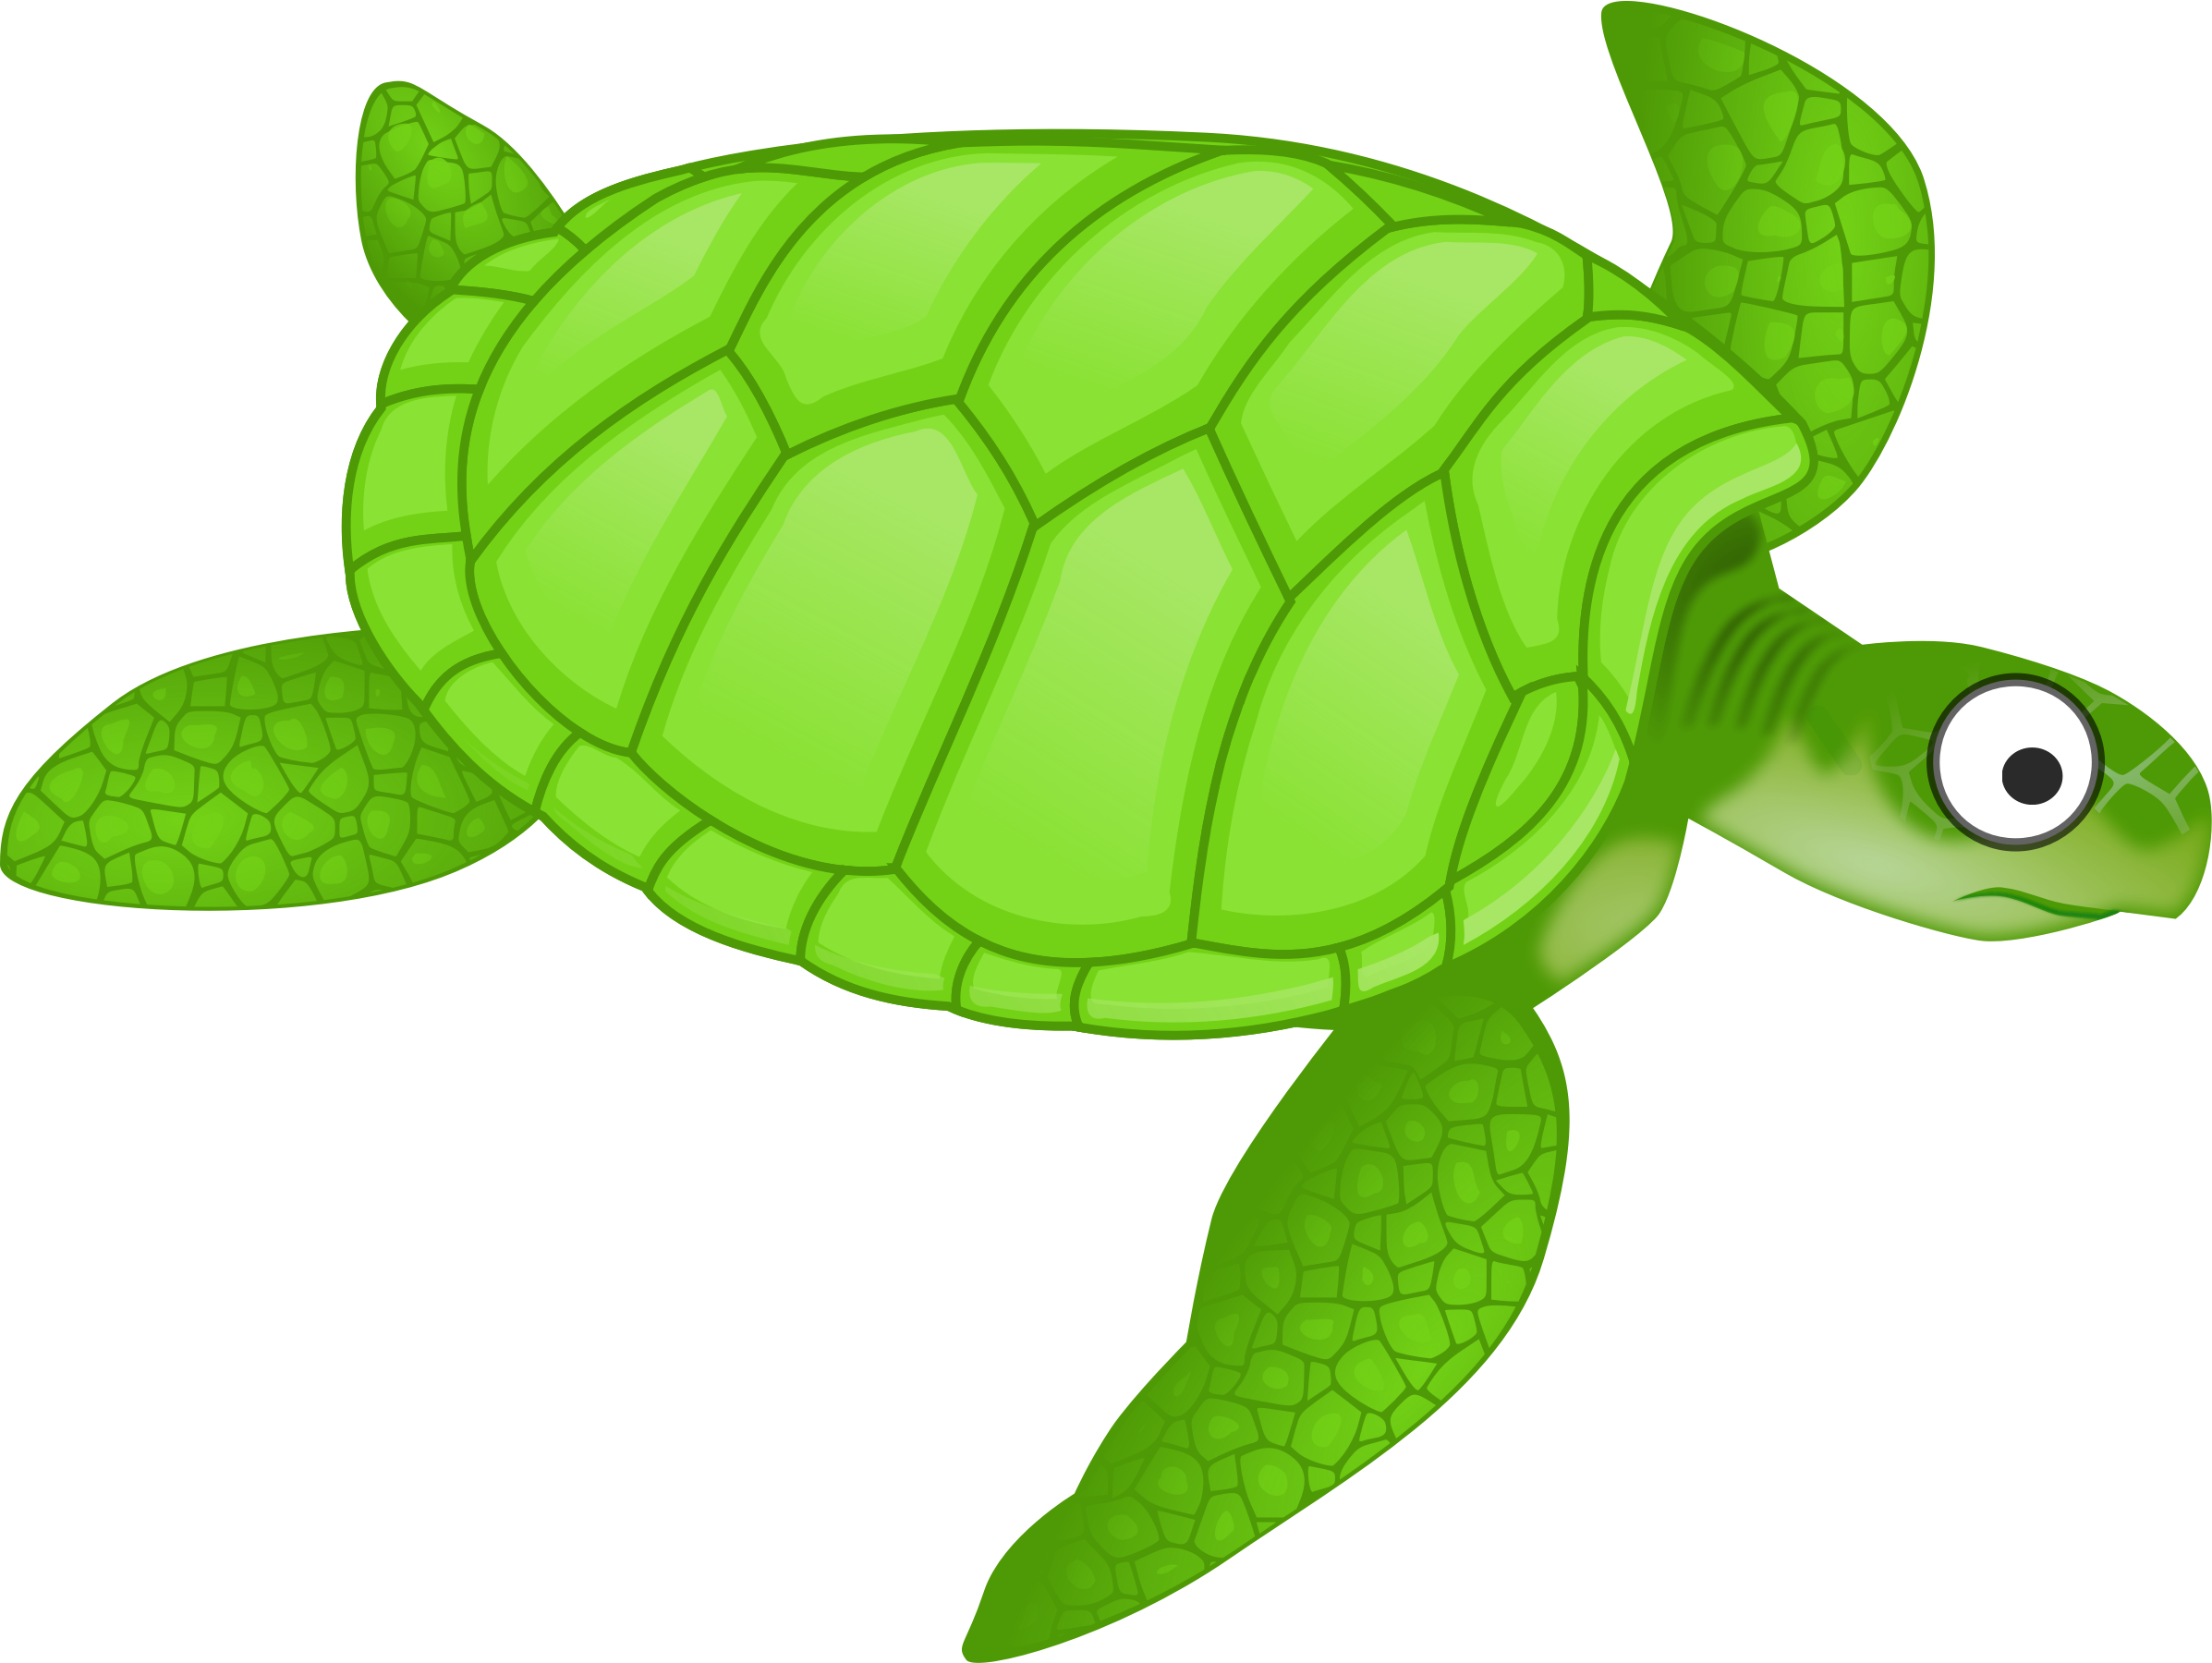

In [ ]:
turtle_image

In [ ]:
# to create the training set, we will resize the turtle image to 256x256
turtle_image_256x256 = turtle_image.resize((256, 256))

# Datset creation

##### Use this part of the notebook to mention your ideas on creatting dataset to train the model for our required task

Below are some ideas to generate new dataset (out of one image) for the purpose of preparing a training set.

-Geometric Transformations: for example apply below changes
Rotation:
Flipping:
Scaling:
Translation:

-Color Transformations: for example apply below changes
Brightness Adjustment:
Contrast Adjustment:
Saturation Adjustment:
Hue Adjustment:

-Noise Addition: for example apply below changes
Gaussian Noise:
Salt-and-Pepper Noise:
Speckle Noise:

-Blurring and Sharpening: for example apply below changes
Gaussian Blur:
Motion Blur:
Sharpening:

-Random Cropping and Padding: for example apply below changes
Random Crop:
Padding:

-GANs: Use Generative Adversarial Networks (GANs) to generate new, similar images.
Style Transfer:

-Finally (preferably in our case): "composite augmentation" or "background replacement," those could be done by using the image segmentation method to extract the foreground object (in our case turtle) from the original image. Then, place it on another real-life images that we can download from public dataset.


---



# Training Set


# Test Image
Now, let's load the test image. As mentioned above, it is of a slightly higher 512x512 resolution.

Downloading...
From: https://drive.google.com/uc?id=1-AtNtzOIA7gHVGBYMiIGvqBWp8UkYChI
To: /content/test.png
100%|██████████| 413k/413k [00:00<00:00, 5.54MB/s]


RGB (512, 512)


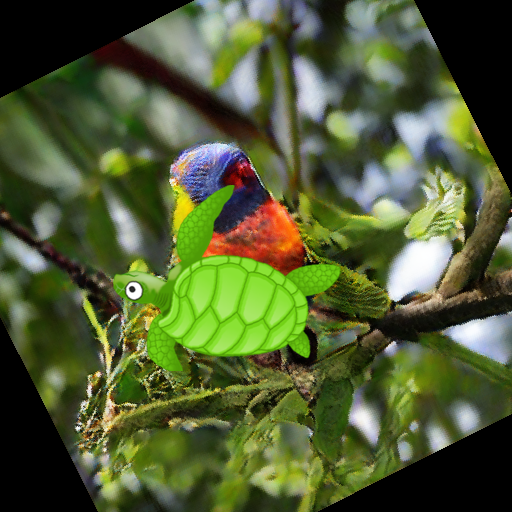

In [ ]:
gdown.download("https://drive.google.com/uc?id=1-AtNtzOIA7gHVGBYMiIGvqBWp8UkYChI", "test.png", quiet=False)
test_image = Image.open('./test.png')
# it is a 3-channel RGB image of size 512x512
print(test_image.mode, test_image.size)
test_image

# Task 1: Predicting segmentation mask

*Here you need to implement your cv/deep learning solution. Your approach must output a result at the native 512x512 resolution of the test image.*

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

tensor_transform = transforms.ToTensor()

# TODO: Implement and train the deep model

# TODO: Save the model weights and upload them to Google Drive

load_model_weights = False
if load_model_weights:
    # After uploading your saved model weights to Google Drive, share to
    # "Anyone with the link" and extract FILE_ID from the share link
    # See https://support.google.com/drive/answer/2494822?hl=en&co=GENIE.Platform%3DDesktop
    # for more information
    # Now the weights can be downloaded and used via gdown:
    saved_model_url = "https://drive.google.com/uc?id=FILE_ID"
    gdown.download(saved_model_url, "saved_model.pth", quiet=True)

    # TODO: Load your saved model weights e.g. torch.load("saved_model.pth")

test_image_tensor = tensor_transform(test_image)

def get_mask_from_image(test_image):
  # TODO: Use the deep model that predicts the segmentation mask on the test image
  # The model with the saved weights should be used, if load_model_weights is True
  test_mask = test_image.mean(0) < 0.5
  return test_mask.byte()

test_mask_tensor = get_mask_from_image(test_image_tensor)

plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.imshow(test_image_tensor.numpy().transpose(1, 2, 0))
plt.subplot(122)
plt.imshow(test_mask_tensor.numpy(), cmap="gray", vmin=0, vmax=1)

NameError: name 'test_image' is not defined

# Task 2: Calculating tight enclosing polygon from segmentation mask

*Here you need to implement your algorithm that predicts a **convex hull** (not concave), an enclosing polygon of foreground pixels. You are not allowed to use cv2, scikit-image or other libraries' functionality that readily solve this task.*

*You don't have to use PyTorch for this part. Your approach must output a result at the native 512x512 resolution of the test image.*

*For the purposes of this assignment, O(n^2) is considered a good time complexity*

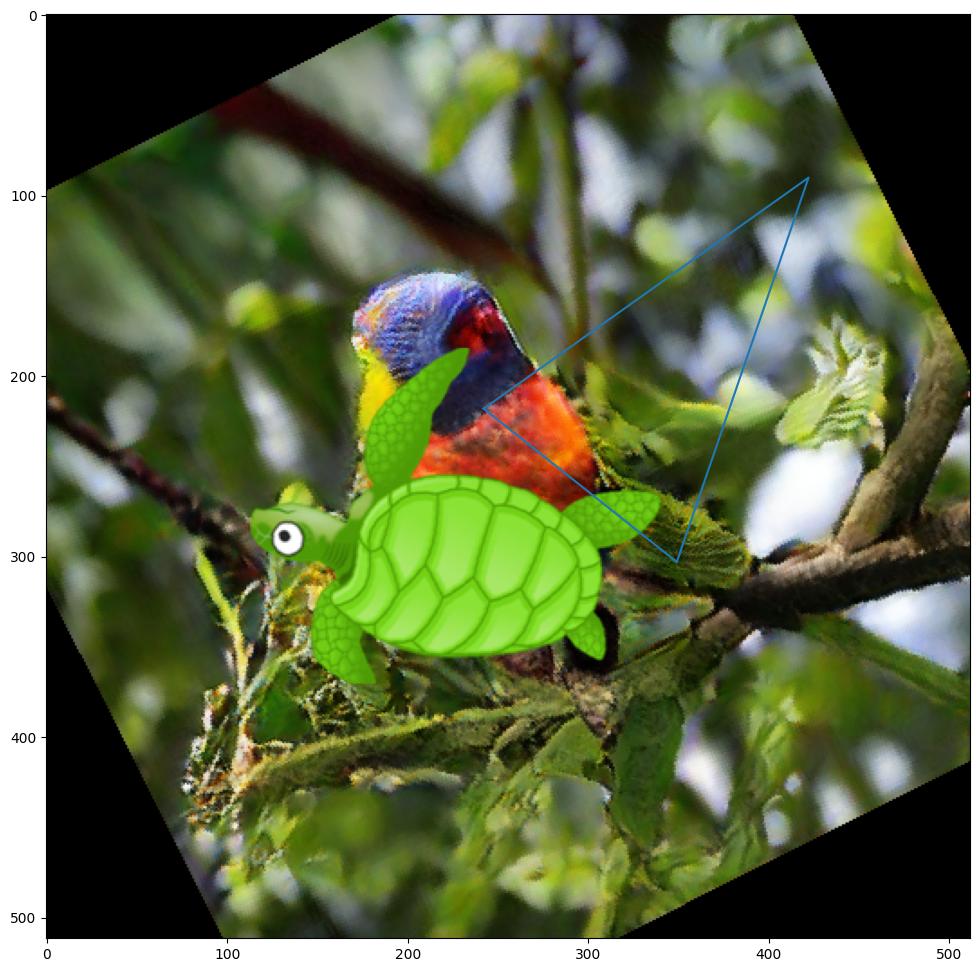

In [ ]:
def get_tight_polygon_from_mask(test_mask):
  # TODO: Implement an algorithm that computes the enclosing polygon from the segmentation mask.
  mask_points_n2 = torch.stack(torch.where(test_mask_tensor == 1), 1)
  dummy_polygon_points_n2 = mask_points_n2[torch.randperm(mask_points_n2.size(0))[:3], :]
  return dummy_polygon_points_n2

def visualize_polygon_on_image(test_image, polygon_points_n2):
  # append first point to close the figure
  polygon_points_n2 = torch.cat([polygon_points_n2, polygon_points_n2[:1]], 0)
  ys, xs = torch.split(polygon_points_n2, 1, dim=-1)
  plt.figure(figsize=(12, 12))
  plt.imshow(test_image.numpy().transpose(1, 2, 0))
  plt.plot(xs.numpy(), ys.numpy())


polygon_points_n2_tensor = get_tight_polygon_from_mask(test_mask_tensor)
visualize_polygon_on_image(test_image_tensor, polygon_points_n2_tensor)


# Task 3: Calculating the area of the polygon

<!-- > Indented block -->


*Here you need to implement your area calculation algorithm. You are not allowed to use cv2, scikit-image or other libraries' functionality that readily solve this task*

*You don't have to use PyTorch for this part. Your approach must output a result at the native 512x512 resolution of the test image.*

In [ ]:
def calculate_polygon_area(polygon_points_n2):
  # TODO: Implement the algorithm
  area = 0.0
  return area

print("Area = {:.4f}".format(calculate_polygon_area(polygon_points_n2_tensor)))

Area = 0.0000
